In [ ]:
!git clone https://github.com/daviddelriod/breaching_changes.git

fatal: destination path 'breaching_changes' already exists and is not an empty directory.


In [ ]:
!pip install breaching

import torch
import torchvision
import breaching
import math

import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F 
import torch.optim as optim
import tensorflow as tf


from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from numbers import Number
from google.colab import drive
from PIL import Image
from torchvision import datasets, models, transforms
from collections import OrderedDict

drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.4/181.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 507.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=9bd145ab32bca64708f0bd022b161ec14b1d0772089b6344af216a23b9ff05e4
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


Mounted at /content/drive


In [ ]:
class data_cfg_default:
    modality = "vision"
    size = (5216,)
    classes = 2
    shape = (3, 224, 224)
    normalize = True
    mean = (0.4794, 0.4794, 0.4794)
    std =  (0.2384, 0.2384, 0.2384)


In [ ]:
class ConvNet(torch.nn.Module):
    """ConvNetBN."""

    def __init__(self, width=32, num_classes=2, num_channels=3):
        """Init with width and num classes."""
        super().__init__()
        self.model = torch.nn.Sequential(OrderedDict([
            ('conv0', torch.nn.Conv2d(num_channels, 1 * width, kernel_size=3, padding=1)),
            ('bn0', torch.nn.BatchNorm2d(1 * width)),
            ('relu0', torch.nn.ReLU()),

            ('conv1', torch.nn.Conv2d(1 * width, 2 * width, kernel_size=3, padding=1)),
            ('bn1', torch.nn.BatchNorm2d(2 * width)),
            ('relu1', torch.nn.ReLU()),

            ('conv2', torch.nn.Conv2d(2 * width, 2 * width, kernel_size=3, padding=1)),
            ('bn2', torch.nn.BatchNorm2d(2 * width)),
            ('relu2', torch.nn.ReLU()),

            ('pool1', torch.nn.MaxPool2d(3)),
            ('flatten', torch.nn.Flatten()),
            ('linear', torch.nn.Linear(10952  * width, num_classes))
        ]))

    def forward(self, input):
        return self.model(input)

model = ConvNet()
model.to('cuda:0')   
model.eval()
criterion = nn.CrossEntropyLoss().cuda();

RuntimeError: ignored

In [ ]:
class ConvNet_vb(torch.nn.Module):
    """ConvNetBN."""

    def __init__(self, width=32, num_classes=2, num_channels=3):
        """Init with width and num classes."""
        super().__init__()
        self.model = torch.nn.Sequential(OrderedDict([
            ('conv0', torch.nn.Conv2d(num_channels, 1 * width, kernel_size=3, padding=1)),
            ('bn0', torch.nn.BatchNorm2d(1 * width)),
            ('relu0', torch.nn.ReLU()),

            ('conv1', torch.nn.Conv2d(1 * width, 2 * width, kernel_size=3, padding=1)),
            ('bn1', torch.nn.BatchNorm2d(2 * width)),
            ('relu1', torch.nn.ReLU()),

            ('conv2', torch.nn.Conv2d(2 * width, 2 * width, kernel_size=3, padding=1)),
            ('bn2', torch.nn.BatchNorm2d(2 * width)),
            ('relu2', torch.nn.ReLU()),

            ('pool1', torch.nn.MaxPool2d(3)),
            ('flatten', torch.nn.Flatten()),
            ('var_bottleneck', VariationalBottleneck((10952 * width,))),
            ('linear', torch.nn.Linear(10952  * width, num_classes))
        ]))

    def forward(self, input):
        return self.model(input)

model = ConvNet_vb()
model.to('cuda:0')   
model.eval()
criterion = nn.CrossEntropyLoss().cuda();

In [ ]:
batch_size = 1
data_dir = {
            'train': '/content/drive/MyDrive/Colab Notebooks/chest_xray/train',
            'test': '/content/drive/MyDrive/Colab Notebooks/chest_xray/test',
            'valid': '/content/drive/MyDrive/Colab Notebooks/chest_xray/val',
            }

data_transforms = {
            'train': transforms.Compose([
                        transforms.Resize((224, 224)),
                        #transforms.CenterCrop(224),
                        #transforms.RandomHorizontalFlip(), # randomly flip and rotate
                        #transforms.RandomRotation(10),
                        transforms.ToTensor(),
                        #transforms.Normalize((0.4794, 0.4794, 0.4794), (0.2384, 0.2384, 0.2384)),
                    ]),
    
            'test': transforms.Compose([
                        transforms.Resize((224,224)),
                        transforms.ToTensor(),
                        #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ]),
    
            'valid': transforms.Compose([
                        transforms.Resize((224,224)),
                        transforms.ToTensor(),
                        #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                    ])
            }

data_set={
        'train': torchvision.datasets.ImageFolder(data_dir['train'] ,data_transforms['train']),
        'test': torchvision.datasets.ImageFolder(data_dir['test'], data_transforms['test']),
        'valid': torchvision.datasets.ImageFolder(data_dir['valid'], data_transforms['valid']),
         }

data_loader={
        'train': torch.utils.data.DataLoader(data_set['train'], batch_size=batch_size,shuffle=True),
        'test': torch.utils.data.DataLoader(data_set['test'], batch_size=batch_size,shuffle=False),
        'valid': torch.utils.data.DataLoader(data_set['valid'], batch_size=batch_size,shuffle=False),
        }

### Attack config

In [ ]:
device = torch.device(f'cuda:0') if torch.cuda.is_available() else torch.device('cpu')
setup = dict(device=device, dtype=getattr(torch, 'float'))

In [ ]:
import copy
user = {'user_type': 'local_update', 'user_idx': 1, 'num_data_points': 2, 'provide_buffers': False, 'provide_labels': True, 'provide_num_data_points': True, 'local_diff_privacy': {'gradient_noise': 0.0, 'input_noise': 0.0, 'distribution': 'laplacian', 'per_example_clipping': 0.0}, 'num_local_updates': 4, 'num_data_per_local_update_step': 2, 'local_learning_rate': 0.001, 'provide_local_hyperparams': True}
user = UserMultiStep(model, criterion, data_loader['train'], setup, 1, user )

In [ ]:
cfg.case.data.partition="random"


cfg.case.user.num_data_points = 4
cfg.case.user.num_local_updates = 4
cfg.case.user.num_data_per_local_update_step = 2


# Total variation regularization needs to be smaller on CIFAR-10:
cfg.attack.regularization.total_variation.scale = 1e-3

In [ ]:
cfg_attack = {'type': 'invertinggradients', 'attack_type': 'optimization', 'label_strategy': 'bias-corrected', 'text_strategy': 'run-embedding', 'token_recovery': 'from-labels', 'objective': {'type': 'cosine-similarity', 'scale': 1.0, 'task_regularization': 0.0}, 'restarts': {'num_trials': 1, 'scoring': 'cosine-similarity'}, 'init': 'randn', 'normalize_gradients': False, 'optim': {'optimizer': 'adam', 'signed': 'hard', 'step_size': 0.1, 'boxed': True, 'max_iterations': 8000, 'step_size_decay': 'step-lr', 'langevin_noise': 0.0, 'warmup': 0, 'grad_clip': None, 'callback': 250}, 'augmentations': None, 'differentiable_augmentations': False, 'regularization': {'total_variation': {'scale': 1e-3, 'inner_exp': 1, 'outer_exp': 1}}, 'impl': {'dtype': 'float', 'mixed_precision': False, 'JIT': None}}

In [ ]:
class DotDict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def convert_to_dotdict(d):
    if isinstance(d, dict):
        dotdict = DotDict({key: convert_to_dotdict(value) for key, value in d.items()})
        return dotdict
    else:
        return d
cfg_attack = convert_to_dotdict(cfg_attack)

In [ ]:
attacker_a = prepare_attack(model, criterion, cfg_attack, setup)

    # ## Simulate an attacked FL protocol
    # Server-side computation:
server_payload = [
        dict(
            parameters=[p for p in model.parameters()], buffers=[b for b in model.buffers()], metadata=data_cfg_default
        )
    ]

shared_data, true_user_data = user.compute_local_updates(server_payload)

2 3


In [ ]:
import torch
torch.cuda.empty_cache()


In [ ]:
reconstructed_user_data, stats = attacker_a.reconstruct([server_payload], [shared_data], {}, dryrun=False)

OutOfMemoryError: ignored

In [ ]:
reconstructed_user_data['data'].shape

torch.Size([2, 3, 224, 224])

In [ ]:
metrics = report(reconstructed_user_data, true_user_data, [server_payload], 
                                    model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/breaching/analysis/metrics.py:24: UserWarning: To utilize wavelet SSIM, install pytorch wavelets from https://github.com/fbcotter/pytorch_wavelets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/breaching/analysis/metrics.py:143: UserWarning: To utilize registered PSNR, install kornia.
  warnings.warn("To utilize registered PSN

RuntimeError: ignored

In [ ]:
data_blocks = []
num_samples = 0

        

for idx, data_block in enumerate(data_loader['train']):
  data_blocks += [data_block]
  num_samples += data_block[1].shape[0]

In [ ]:
num_samples

5217

In [ ]:
datapoint, labels = next(iter(data_loader['train']))
datapoint, labels = datapoint[8:10].cuda(), labels[8:10].type(torch.LongTensor).cuda()
datapoint = datapoint.view(2, 3, 224, 224).cuda()

#configs for thwe attack
setup = dict(device=torch.device("cuda:0"), dtype=torch.float)
cfg_attack = breaching.get_attack_config("invertinggradients")
cfg_attack['restarts']['num_trials'] = 1
cfg_attack['optim']['step_size'] = 0.005 #la previa había sido 0.01 y después 0.005
cfg_attack['optim']['max_iterations'] = 50000 #y esto 36 000 y previa 300 000 y 100.000
cfg_attack['regularization']['total_variation']['scale'] = 0.001 #probar 0.0025
#cfg_attack['regularization']['total_variation']['groups'] = 1

Loading attack configuration optimization-invertinggradients.


/usr/local/lib/python3.9/dist-packages/breaching/__init__.py:26: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize(config_path="config/attack"):


In [ ]:
unnormalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)


imgn_unnormalized1 = unnormalize(reconstructed_user_data["data"][16].cpu())
#imgp_unnormalized = unnormalize(imgp_tensor)
# Plot the tensor
plt.imshow(imgn_unnormalized1.permute(1, 2, 0).numpy())
plt.axis('off')
plt.show()

IndexError: ignored

In [ ]:
criterion = nn.NLLLoss()
optimizer = optim.Adadelta(model.parameters())
#train_on_gpu = torch.cuda.is_available()
#scheduler = None
#valid_loss_min = 1 

In [ ]:
# This is the attacker A:
attacker_a = breaching.attacks.prepare_attack(model, criterion, cfg_attack, setup)

    # ## Simulate an attacked FL protocol
    # Server-side computation:
server_payload = [
        dict(
            parameters=[p for p in model.parameters()], buffers=[b for b in model.buffers()], metadata=data_cfg_default
        )
    ]
    # User-side computation:
output = model(datapoint)
output = output.squeeze()
labels = labels
    #label = labels.unsqueeze(0)
#label = labels.unsqueeze(0)
print(output.shape, labels.shape)
loss = criterion(output, labels)
print(loss)

torch.Size([2, 2]) torch.Size([2])
tensor(0.7227, device='cuda:0', grad_fn=<NllLossBackward0>)


In [ ]:
# This is the attacker B:
attacker_b = breaching.attacks.prepare_attack(model_vb, criterion, cfg_attack, setup)

 # ## Simulate an attacked FL protocol
    # Server-side computation:
server_payload_vb = [
        dict(
            parameters=[p for p in model_vb.parameters()], buffers=[b for b in model_vb.buffers()], metadata=data_cfg_default
        )
    ]
    # User-side computation: 
output_vb = model_vb(datapoint)
    #label = labels.unsqueeze(0)
#label = labels.unsqueeze(0)
print(output_vb.shape, labels.shape)
loss_vb = criterion(output_vb, labels)
print(loss_vb)

torch.Size([2, 2]) torch.Size([2])
tensor(4375272.5000, device='cuda:0', grad_fn=<NllLossBackward0>)


In [ ]:
shared_data = [
        dict(  
            gradients=torch.autograd.grad(loss, model.parameters(),  allow_unused=True, retain_graph=True),
            buffers=None,
            metadata=dict(num_data_points = 2, labels = labels, local_hyperparams = None,),
        )
    ] 
    # Attack:  
reconstructed_user_data, stats = attacker_a.reconstruct(server_payload, shared_data, {}, dryrun=False)
print(reconstructed_user_data.keys(), stats.keys())

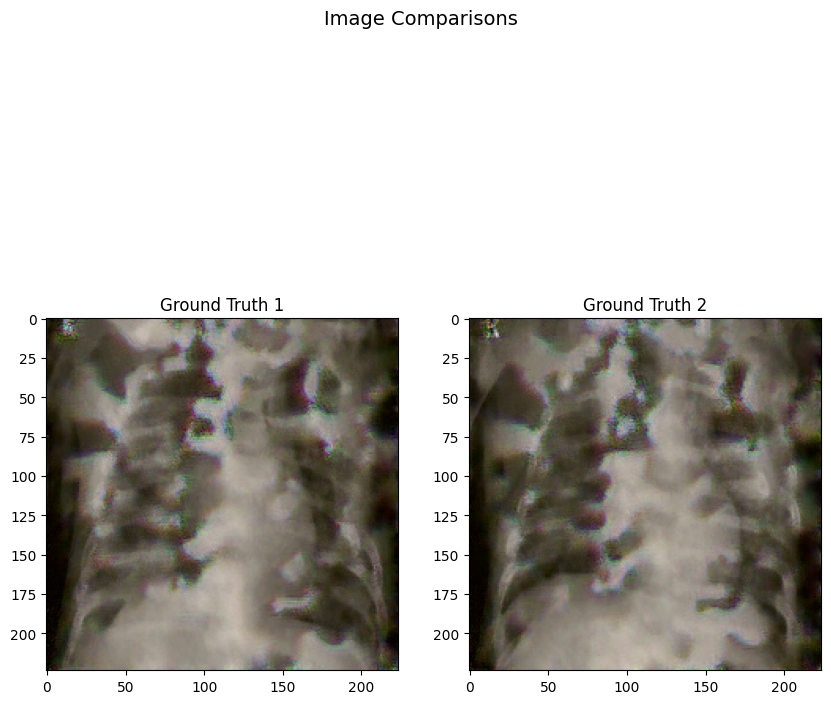

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
unnormalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

imgn_unnormalized = unnormalize(reconstructed_user_data['data'][0])
imgp_unnormalized2 = unnormalize(reconstructed_user_data['data'][1])

image1 = imgn_unnormalized.squeeze().permute(1, 2, 0).cpu().numpy() 
image2 = imgp_unnormalized2.squeeze().permute(1, 2, 0).cpu().numpy() 

#image1_vb = reconstructed_user_data_vb['data'][0].squeeze().permute(1, 2, 0).cpu().numpy() 
#image2_vb = reconstructed_user_data_vb['data'][1].squeeze().permute(1, 2, 0).cpu().numpy()

#gr_truth1 = imgn_unnormalized.permute(1, 2, 0).cpu().numpy()
#gr_truth2 = imgp_unnormalized.permute(1, 2, 0).cpu().numpy()

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10, 10))
fig.suptitle('Image Comparisons', fontsize=14)

ax1.imshow((image1))
ax1.set_title('Ground Truth 1')
ax2.imshow((image2))
ax2.set_title('Ground Truth 2')

plt.show()


In [ ]:
image1.shape

(224, 224, 3)

In [ ]:
unnormalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

image3 = reconstructed_user_data['data'][0].squeeze()#.permute(1, 2, 0).cpu() 
image4 = reconstructed_user_data['data'][1].squeeze()#.permute(1, 2, 0).cpu()
image3 = unnormalize(image3)
image4 = unnormalize(image4)


unnormalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

image1 = unnormalize(datapoint[0])
image2 = unnormalize(datapoint[1])

gr_truth1 = image1.permute(1, 2, 0).cpu().numpy()
gr_truth2 = image2.permute(1, 2, 0).cpu().numpy()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Image Comparisons', fontsize=14)

ax1.imshow(gr_truth1)
ax1.set_title('Ground Truth 1')
ax2.imshow(gr_truth2)
ax2.set_title('Ground Truth 2')

ax3.imshow(image3.permute(1, 2, 0).cpu())
ax3.set_title('Reconstructed 1')
ax4.imshow(image4.permute(1, 2, 0).cpu())
ax4.set_title('Reconstructed 2')

# ax5.imshow((image1_vb * 255).astype(np.uint8))
# ax5.set_title('Variational Bayes Reconstructed 1')
# ax6.imshow((image2_vb * 255).astype(np.uint8))
# ax6.set_title('Variational Bayes Reconstructed 2')

plt.show()


In [ ]:
class VariationalBottleneck(torch.nn.Module):
    """
    Implementation inspired by https://github.com/1Konny/VIB-pytorch/blob/master/model.py
    """
    def __init__(self, in_shape, K=256, beta=1e-3, *args, **kwargs):
        super().__init__()
        self.in_shape = in_shape
        self.K = K
        self.beta = beta

        if len(in_shape) == 1: # previous layer is a Linear layer
            enc_in_dim = in_shape[0]
            self.reducer = None
        elif len(in_shape) == 3:
            enc_in_dim = np.prod(in_shape)
            self.reducer = None
        else: 
            enc_in_dim = np.prod(in_shape[1:])
            self.reducer = nn.Conv2d(in_shape[0], 1, 1)

        self.encoder = nn.Linear(enc_in_dim, 2 * self.K)
        self.decoder = nn.Linear(self.K, np.prod(in_shape))

        self.mu = Variable(torch.Tensor(K))
        self.std = Variable(torch.Tensor(K))
        self.out_feats = Variable(torch.Tensor(in_shape))

    def forward(self, x):
        batch_size = x.shape[0]
        x_out = x
        if x.dim() > 2 and x.shape[1] > 1 and self.reducer != None:
            x = self.reducer(x)

        if x.dim() > 2:
            x = x.view(x.size(0), -1)

        statistics = self.encoder(x)
        
        mu = statistics[:, :self.K]
        std = F.softplus(statistics[:, self.K:])
        self.mu = mu
        self.std = std
    
        encoding = self.reparameterize(mu, std) # pull sample from the distribution

        x = self.decoder(encoding.unsqueeze(0))
        x_out = x.view((batch_size, *self.in_shape))
        self.out_feats = x_out

        return x_out


    def reparameterize(self, mu, std):
        def check_number(vector):
            if isinstance(vector, Number):
                return torch.Tensor([vector])
            else:
                return vector

        mu = check_number(mu)
        std = check_number(std)
        eps = Variable(std.data.new(std.size()).normal_().to(mu.device))

        return mu + eps * std

    def loss(self):
        return self.beta * (-0.5*(1+2*self.std.log()-self.mu.pow(2)-self.std.pow(2)).sum(1).mean().div(math.log(2))) 

In [ ]:
class UserSingleStep(torch.nn.Module):
    """A user who computes a single local update step."""

    def __init__(self, model, loss, dataloader, setup, idx, cfg_user):
        """Initialize from cfg_user dict which contains atleast all keys in the matching .yaml :>"""
        super().__init__()
        self.num_data_points = cfg_user['num_data_points']

        self.provide_labels = cfg_user['provide_labels']
        self.provide_num_data_points = cfg_user['provide_num_data_points']
        self.provide_buffers = cfg_user['provide_buffers']

        self.user_idx = idx
        self.setup = setup

        self.model = copy.deepcopy(model)
        self.model.to(**setup)

        self.defense_repr = []
        self._initialize_local_privacy_measures(cfg_user['local_diff_privacy'])

        self.dataloader = dataloader
        self.loss = copy.deepcopy(loss)  # Just in case the loss contains state

        self.counted_queries = 0  # Count queries to this user

    def __repr__(self):
        n = "\n"
        return f"""User (of type {self.__class__.__name__}) with settings:
    Number of data points: {self.num_data_points}

    Threat model:
    User provides labels: {self.provide_labels}
    User provides buffers: {self.provide_buffers}
    User provides number of data points: {self.provide_num_data_points}

    Data:
    Dataset: {self.dataloader.name}
    user: {self.user_idx}
    {n.join(self.defense_repr)}
        """

    def _initialize_local_privacy_measures(self, local_diff_privacy):
        """Initialize generators for noise in either gradient or input."""
        if local_diff_privacy["gradient_noise"] > 0.0:
            loc = torch.as_tensor(0.0, **self.setup)
            scale = torch.as_tensor(local_diff_privacy["gradient_noise"], **self.setup)
            if local_diff_privacy["distribution"] == "gaussian":
                self.generator = torch.distributions.normal.Normal(loc=loc, scale=scale)
            elif local_diff_privacy["distribution"] == "laplacian":
                self.generator = torch.distributions.laplace.Laplace(loc=loc, scale=scale)
            else:
                raise ValueError(f'Invalid distribution {local_diff_privacy["distribution"]} given.')
            self.defense_repr.append(
                f'Defense: Local {local_diff_privacy["distribution"]} gradient noise with strength {scale.item()}.'
            )
        else:
            self.generator = None
        if local_diff_privacy["input_noise"] > 0.0:
            loc = torch.as_tensor(0.0, **self.setup)
            scale = torch.as_tensor(local_diff_privacy["input_noise"], **self.setup)
            if local_diff_privacy["distribution"] == "gaussian":
                self.generator_input = torch.distributions.normal.Normal(loc=loc, scale=scale)
            elif local_diff_privacy["distribution"] == "laplacian":
                self.generator_input = torch.distributions.laplace.Laplace(loc=loc, scale=scale)
            else:
                raise ValueError(f'Invalid distribution {local_diff_privacy["distribution"]} given.')
            self.defense_repr.append(
                f'Defense: Local {local_diff_privacy["distribution"]} input noise with strength {scale.item()}.'
            )
        else:
            self.generator_input = None
        self.clip_value = local_diff_privacy.get("per_example_clipping", 0.0)
        if self.clip_value > 0:
            self.defense_repr.append(f"Defense: Gradient clipping to maximum of {self.clip_value}.")

    def compute_local_updates(self, server_payload, custom_data=None):
        """Compute local updates to the given model based on server payload.

        Batchnorm behavior:
        If public buffers are sent by the server, then the user will be set into evaluation mode
        Otherwise the user is in training mode and sends back buffer based on .provide_buffers.

        Shared labels are canonically sorted for simplicity.

        Optionally custom data can be directly inserted here, superseding actual user data.
        Use this behavior only for demonstrations.
        """
        self.counted_queries += 1
        if custom_data is None:
            data = self._load_data()
        else:
            data = custom_data
        B = data["labels"].shape[0]
        # Compute local updates
        shared_grads = []
        shared_buffers = []
        parameters = server_payload["parameters"]
        buffers = server_payload["buffers"]

        with torch.no_grad():
            for param, server_state in zip(self.model.parameters(), parameters):
                param.copy_(server_state.to(**self.setup))
            if buffers is not None:
                for buffer, server_state in zip(self.model.buffers(), buffers):
                    buffer.copy_(server_state.to(**self.setup))
                self.model.eval()
            else:
                for module in self.model.modules():
                    if hasattr(module, "momentum"):
                        module.momentum = None  # Force recovery without division
                self.model.train()
        log.info(
            f"Computing user update on user {self.user_idx} in model mode: {'training' if self.model.training else 'eval'}."
        )

        def _compute_batch_gradient(data):
            data[self.data_key] = (
                data[self.data_key] + self.generator_input.sample(data[self.data_key].shape)
                if self.generator_input is not None
                else data[self.data_key]
            )
            outputs = self.model(**data)
            loss = self.loss(outputs, data["labels"])
            return torch.autograd.grad(loss, self.model.parameters())

        if self.clip_value > 0:  # Compute per-example gradients and clip them in this case
            shared_grads = [torch.zeros_like(p) for p in self.model.parameters()]
            for data_idx in range(B):
                data_point = {key: val[data_idx : data_idx + 1] for key, val in data.items()}
                per_example_grads = _compute_batch_gradient(data_point)
                self._clip_list_of_grad_(per_example_grads)
                torch._foreach_add_(shared_grads, per_example_grads)
            torch._foreach_div_(shared_grads, B)
        else:
            # Compute the forward pass
            shared_grads = _compute_batch_gradient(data)
        self._apply_differential_noise(shared_grads)

        if buffers is not None:
            shared_buffers = None
        else:
            shared_buffers = [b.clone().detach() for b in self.model.buffers()]

        metadata = dict(
            num_data_points=self.num_data_points if self.provide_num_data_points else None,
            labels=data["labels"].sort()[0] if self.provide_labels else None,
            local_hyperparams=None,
        )
        shared_data = dict(
            gradients=shared_grads, buffers=shared_buffers if self.provide_buffers else None, metadata=metadata
        )
        true_user_data = dict(data=data[self.data_key], labels=data["labels"], buffers=shared_buffers)

        return shared_data, true_user_data

    def _clip_list_of_grad_(self, grads):
        """Apply differential privacy component per-example clipping."""
        grad_norm = torch.norm(torch.stack([torch.norm(g, 2) for g in grads]), 2)
        if grad_norm > self.clip_value:
            [g.mul_(self.clip_value / (grad_norm + 1e-6)) for g in grads]

    def _apply_differential_noise(self, grads):
        """Apply differential privacy component gradient noise."""
        if self.generator is not None:
            for grad in grads:
                grad += self.generator.sample(grad.shape)

    def _load_data(self, setup=None):
        """Generate data from dataloader, truncated by self.num_data_points"""
        # Select data
        data_blocks = []
        num_samples = 0

        if setup is None:
            setup = self.setup

        for idx, data_block in enumerate(self.dataloader):
            data_blocks.append({'inputs': data_block[0],'labels': data_block[1]})
            num_samples += data_block[1].shape[0]
            
            if num_samples > self.num_data_points:
                break
        print(self.num_data_points, num_samples)
        if num_samples < self.num_data_points:
            raise ValueError(
                f"This user does not have the requested {self.num_data_points} samples,"
                f"they only own {num_samples} samples."
            )

        data = dict()
        for key in data_blocks[0]:
            data[key] = torch.cat([d[key] for d in data_blocks], dim=0)[: self.num_data_points].to(
                device=setup["device"]
            )

        self.data_key = "input_ids" if "input_ids" in data.keys() else "inputs"
        return data

    def print(self, user_data, **kwargs):
        """Print decoded user data to output."""
        tokenizer = self.dataloader.dataset.tokenizer
        decoded_tokens = tokenizer.batch_decode(user_data["data"], clean_up_tokenization_spaces=True)
        for line in decoded_tokens:
            print(line)

    def print_with_confidence(self, user_data, **kwargs):
        """Print decoded user data to output."""
        tokenizer = self.dataloader.dataset.tokenizer
        colors = [160, 166, 172, 178, 184, 190]
        thresholds = torch.as_tensor([0, 0.5, 0.75, 0.95, 0.99, 0.9999])

        def bg_color(text, confidence_score):
            threshold = ((confidence_score > thresholds) + torch.arange(0, len(colors)) / 100).argmax()
            return "\33[48;5;" + str(colors[threshold]) + "m" + text + "\33[0m"

        for sequence, sequence_confidence in zip(user_data["data"], user_data["confidence"]):
            for token, c in zip(sequence, sequence_confidence):
                decoded_token = tokenizer.decode(token)
                print(bg_color(decoded_token + " ", c), end="")
            print("\n")

    def print_and_mark_correct(self, user_data, true_user_data, **kwargs):
        """Print decoded user data to output."""
        tokenizer = self.dataloader.dataset.tokenizer

        def bg_color(text, correct):
            if correct:
                return "\33[48;5;190m" + text + "\33[0m"
            else:
                return "\33[48;5;160m" + text + "\33[0m"

        for sequence, gt_sequence in zip(user_data["data"], true_user_data["data"]):
            for token, gt_token in zip(sequence, gt_sequence):
                decoded_token = tokenizer.decode(token)
                print(bg_color(decoded_token + " ", token == gt_token), end="")
            print("\n")

    def plot(self, user_data, scale=False, print_labels=False):
        """Plot user data to output. Probably best called from a jupyter notebook."""
        import matplotlib.pyplot as plt  # lazily import this here

        #dm = torch.as_tensor(self.dataloader.dataset.mean, **self.setup)[None, :, None, None]
        #ds = torch.as_tensor(self.dataloader.dataset.std, **self.setup)[None, :, None, None]
        dm_values = [0.4794, 0.4794, 0.4794]
        ds_values = [0.2384, 0.2384, 0.2384]
        dm = torch.tensor(dm_values).unsqueeze(1).unsqueeze(1).cuda()
        ds = torch.tensor(ds_values).unsqueeze(1).unsqueeze(1).cuda()
        classes = self.dataloader.dataset.classes

        data = user_data["data"].clone().detach()
        labels = user_data["labels"].clone().detach() if user_data["labels"] is not None else None
        if labels is None:
            print_labels = False

        if scale:
            min_val, max_val = data.amin(dim=[2, 3], keepdim=True), data.amax(dim=[2, 3], keepdim=True)
            # print(f'min_val: {min_val} | max_val: {max_val}')
            data = (data - min_val) / (max_val - min_val)
        else:
            data.mul_(ds).add_(dm).clamp_(0, 1)
        data = data.to(dtype=torch.float32)

        if data.shape[0] == 1:
            plt.axis("off")
            plt.imshow(data[0].permute(1, 2, 0).cpu())
            if print_labels:
                plt.title(f"Data with label {classes[labels]}")
        else:
            grid_shape = int(torch.as_tensor(data.shape[0]).sqrt().ceil())
            s = 24 if data.shape[3] > 150 else 6
            fig, axes = plt.subplots(grid_shape, grid_shape, figsize=(s, s))
            label_classes = []
            for i, (im, axis) in enumerate(zip(data, axes.flatten())):
                axis.imshow(im.permute(1, 2, 0).cpu())
                if labels is not None and print_labels:
                    label_classes.append(classes[labels[i]])
                axis.axis("off")
            if print_labels:
                print(label_classes)

class UserMultiStep(UserSingleStep):
    """A user who computes multiple local update steps as in a FedAVG scenario."""

    def __init__(self, model, loss, dataloader, setup, idx, cfg_user):
        """Initialize but do not propagate the cfg_case.user dict further."""
        super().__init__(model, loss, dataloader, setup, idx, cfg_user)

        self.num_local_updates = cfg_user['num_local_updates']
        self.num_data_per_local_update_step = cfg_user['num_data_per_local_update_step']
        self.local_learning_rate = cfg_user['local_learning_rate']
        self.provide_local_hyperparams = cfg_user['provide_local_hyperparams']

    def __repr__(self):
        n = "\n"
        return (
            super().__repr__()
            + n
            + f"""    Local FL Setup:
        Number of local update steps: {self.num_local_updates}
        Data per local update step: {self.num_data_per_local_update_step}
        Local learning rate: {self.local_learning_rate}

        Threat model:
        Share these hyperparams to server: {self.provide_local_hyperparams}

        """
        )

    def compute_local_updates(self, server_payload):
        """Compute local updates to the given model based on server payload."""
        self.counted_queries += 1
        user_data = self._load_data()

        # Compute local updates
        server_payload = server_payload[0]
        parameters = server_payload["parameters"]
        buffers = server_payload["buffers"]

        with torch.no_grad():
            for param, server_state in zip(self.model.parameters(), parameters):
                param.copy_(server_state.to(**self.setup))
            if buffers is not None:
                for buffer, server_state in zip(self.model.buffers(), buffers):
                    buffer.copy_(server_state.to(**self.setup))
                self.model.eval()
            else:
                self.model.train()
        log.info(
            f"Computing user update on user {self.user_idx} in model mode: {'training' if self.model.training else 'eval'}."
        )

        optimizer = torch.optim.SGD(self.model.parameters(), lr=self.local_learning_rate)
        seen_data_idx = 0
        label_list = []
        for step in range(self.num_local_updates):
            data = {
                k: v[seen_data_idx : seen_data_idx + self.num_data_per_local_update_step] for k, v in user_data.items()
            }
            seen_data_idx += self.num_data_per_local_update_step
            seen_data_idx = seen_data_idx % self.num_data_points
            label_list.append(data["labels"].sort()[0])

            optimizer.zero_grad()
            # Compute the forward pass
            data[self.data_key] = (
                data[self.data_key] + self.generator_input.sample(data[self.data_key].shape)
                if self.generator_input is not None
                else data[self.data_key]
            )
            #print(data, type(data))
            outputs = self.model(data['inputs'])
            loss = self.loss(outputs, data["labels"])
            loss.backward()

            grads_ref = [p.grad for p in self.model.parameters()]
            if self.clip_value > 0:
                self._clip_list_of_grad_(grads_ref)
            self._apply_differential_noise(grads_ref)
            optimizer.step()

        # Share differential to server version:
        # This is equivalent to sending the new stuff and letting the server do it, but in line
        # with the gradients sent in UserSingleStep
        shared_grads = [
            (p_local - p_server.to(**self.setup)).clone().detach()
            for (p_local, p_server) in zip(self.model.parameters(), parameters)
        ]

        shared_buffers = [b.clone().detach() for b in self.model.buffers()]
        metadata = dict(
            num_data_points=self.num_data_points if self.provide_num_data_points else None,
            labels=user_data["labels"] if self.provide_labels else None,
            local_hyperparams=dict(
                lr=self.local_learning_rate,
                steps=self.num_local_updates,
                data_per_step=self.num_data_per_local_update_step,
                labels=label_list,
            )
            if self.provide_local_hyperparams
            else None,
            data_key=self.data_key,
        )
        shared_data = dict(
            gradients=shared_grads, buffers=shared_buffers if self.provide_buffers else None, metadata=metadata
        )
        true_user_data = dict(data=user_data[self.data_key], labels=user_data["labels"], buffers=shared_buffers)

        return shared_data, true_user_data


In [ ]:
def prepare_attack(model, loss, cfg_attack, setup=dict(dtype=torch.float, device=torch.device("cpu"))):
    if cfg_attack['attack_type'] == "optimization":
        attacker = OptimizationBasedAttacker(model, loss, cfg_attack, setup)
    elif cfg_attack['attack_type'] == "multiscale":
        attacker = breaching.attacks.MultiScaleOptimizationAttacker(model, loss, cfg_attack, setup)
    elif cfg_attack['attack_type'] == "analytic":
        attacker = breaching.attacks.AnalyticAttacker(model, loss, cfg_attack, setup)
    elif cfg_attack['attack_type'] == "april-analytic":
        attacker = breaching.attacks.AprilAttacker(model, loss, cfg_attack, setup)
    elif cfg_attack['attack_type'] == "imprint-readout":
        attacker = breaching.attacks.ImprintAttacker(model, loss, cfg_attack, setup)
    elif cfg_attack['attack_type'] == "decepticon-readout":
        attacker = breaching.attacks.DecepticonAttacker(model, loss, cfg_attack, setup)
    elif cfg_attack['attack_type'] == "recursive":
        attacker = breaching.attacks.RecursiveAttacker(model, loss, cfg_attack, setup)
    elif cfg_attack['attack_type'] == "joint-optimization":
        attacker = breaching.attacks.OptimizationJointAttacker(model, loss, cfg_attack, setup)
    elif cfg_attack['attack_type'] == "permutation-optimization":
        attacker = breaching.attacks.OptimizationPermutationAttacker(model, loss, cfg_attack, setup)
    else:
        raise ValueError(f"Invalid type of attack {cfg_attack.attack_type} given.")

    return attacker

In [ ]:
"""Implementation for basic gradient inversion attacks.

This covers optimization-based reconstruction attacks as in Wang et al. "Beyond Infer-
ring Class Representatives: User-Level Privacy Leakage From Federated Learning."
and convers subsequent developments such as
* Zhu et al., "Deep Leakage from gradients",
* Geiping et al., "Inverting Gradients - How easy is it to break privacy in FL"
* ?
"""

import torch
import time

#from .base_attack import _BaseAttacker
from breaching.attacks.auxiliaries.regularizers import regularizer_lookup, TotalVariation
from breaching.attacks.auxiliaries.objectives import Euclidean, CosineSimilarity, objective_lookup
from breaching.attacks.auxiliaries.augmentations import augmentation_lookup

import logging

log = logging.getLogger(__name__)


class OptimizationBasedAttacker(_BaseAttacker):
    """Implements a wide spectrum of optimization-based attacks."""

    def __init__(self, model, loss_fn, cfg_attack, setup=dict(dtype=torch.float, device=torch.device("cpu"))):
        super().__init__(model, loss_fn, cfg_attack, setup)
        objective_fn = objective_lookup.get(self.cfg.objective.type)
        if objective_fn is None:
            raise ValueError(f"Unknown objective type {self.cfg.objective.type} given.")
        else:
            self.objective = objective_fn(**self.cfg.objective)
        self.regularizers = []
        try:
            for key in self.cfg.regularization.keys():
                if self.cfg.regularization[key].scale > 0:
                    self.regularizers += [regularizer_lookup[key](self.setup, **self.cfg.regularization[key])]
        except AttributeError:
            pass  # No regularizers selected.

        try:
            self.augmentations = []
            for key in self.cfg.augmentations.keys():
                self.augmentations += [augmentation_lookup[key](**self.cfg.augmentations[key])]
            self.augmentations = torch.nn.Sequential(*self.augmentations).to(**setup)
        except AttributeError:
            self.augmentations = torch.nn.Sequential()  # No augmentations selected.

    def __repr__(self):
        n = "\n"
        return f"""Attacker (of type {self.__class__.__name__}) with settings:
    Hyperparameter Template: {self.cfg.type}

    Objective: {repr(self.objective)}
    Regularizers: {(n + ' '*18).join([repr(r) for r in self.regularizers])}
    Augmentations: {(n + ' '*18).join([repr(r) for r in self.augmentations])}

    Optimization Setup:
        {(n + ' ' * 8).join([f'{key}: {val}' for key, val in self.cfg.optim.items()])}
        """

    def reconstruct(self, server_payload, shared_data, server_secrets=None, initial_data=None, dryrun=False):
        # Initialize stats module for later usage:
        rec_models, labels, stats = self.prepare_attack(server_payload, shared_data)
        # Main reconstruction loop starts here:
        scores = torch.zeros(self.cfg.restarts.num_trials)
        candidate_solutions = []
        try:
            for trial in range(self.cfg.restarts.num_trials):
                candidate_solutions += [
                    self._run_trial(rec_models, shared_data, labels, stats, trial, initial_data, dryrun)
                ]
                scores[trial] = self._score_trial(candidate_solutions[trial], labels, rec_models, shared_data)
        except KeyboardInterrupt:
            print("Trial procedure manually interruped.")
            pass
        optimal_solution = self._select_optimal_reconstruction(candidate_solutions, scores, stats)
        reconstructed_data = dict(data=optimal_solution, labels=labels)
        #if server_payload[0][0]["metadata"].modality == "text":
         #   reconstructed_data = self._postprocess_text_data(reconstructed_data)
        if "ClassAttack" in server_secrets:
            # Only a subset of images was actually reconstructed:
            true_num_data = server_secrets["ClassAttack"]["true_num_data"]
            reconstructed_data["data"] = torch.zeros([true_num_data, *self.data_shape], **self.setup)
            reconstructed_data["data"][server_secrets["ClassAttack"]["target_indx"]] = optimal_solution
            reconstructed_data["labels"] = server_secrets["ClassAttack"]["all_labels"]
        return reconstructed_data, stats

    def _run_trial(self, rec_model, shared_data, labels, stats, trial, initial_data=None, dryrun=False):
        """Run a single reconstruction trial."""

        # Initialize losses:
        for regularizer in self.regularizers:
            regularizer.initialize(rec_model, shared_data, labels)
        self.objective.initialize(self.loss_fn, self.cfg.impl, shared_data[0]["metadata"]["local_hyperparams"])

        # Initialize candidate reconstruction data
        candidate = self._initialize_data([shared_data[0]["metadata"]["num_data_points"], *self.data_shape])
        if initial_data is not None:
            candidate.data = initial_data.data.clone().to(**self.setup)

        best_candidate = candidate.detach().clone()
        minimal_value_so_far = torch.as_tensor(float("inf"), **self.setup)

        # Initialize optimizers
        optimizer, scheduler = self._init_optimizer([candidate])
        current_wallclock = time.time()
        try:
            for iteration in range(self.cfg.optim.max_iterations):
                closure = self._compute_objective(candidate, labels, rec_model, optimizer, shared_data, iteration)
                objective_value, task_loss = optimizer.step(closure), self.current_task_loss
                scheduler.step()

                with torch.no_grad():
                    # Project into image space
                    if self.cfg.optim.boxed:
                        candidate.data = torch.max(torch.min(candidate, (1 - self.dm) / self.ds), -self.dm / self.ds)
                    if objective_value < minimal_value_so_far:
                        minimal_value_so_far = objective_value.detach()
                        best_candidate = candidate.detach().clone()

                if iteration + 1 == self.cfg.optim.max_iterations or iteration % self.cfg.optim.callback == 0:
                    timestamp = time.time()
                    print(
                        f"| It: {iteration + 1} | Rec. loss: {objective_value.item():2.4f} | "
                        f" Task loss: {task_loss.item():2.4f} | T: {timestamp - current_wallclock:4.2f}s"
                    )
                    current_wallclock = timestamp

                if not torch.isfinite(objective_value):
                    log.info(f"Recovery loss is non-finite in iteration {iteration}. Cancelling reconstruction!")
                    break

                stats[f"Trial_{trial}_Val"].append(objective_value.item())

                if dryrun:
                    break
        except KeyboardInterrupt:
            print(f"Recovery interrupted manually in iteration {iteration}!")
            pass

        return best_candidate.detach()

    def _compute_objective(self, candidate, labels, rec_model, optimizer, shared_data, iteration):
        def closure():
            optimizer.zero_grad()

            if self.cfg.differentiable_augmentations:
                candidate_augmented = self.augmentations(candidate)
            else:
                candidate_augmented = candidate
                candidate_augmented.data = self.augmentations(candidate.data)

            total_objective = 0
            total_task_loss = 0
            for model, data in zip(rec_model, shared_data):
                objective, task_loss = self.objective(model, data["gradients"], candidate_augmented, labels)
                total_objective += objective
                total_task_loss += task_loss
            for regularizer in self.regularizers:
                total_objective += regularizer(candidate_augmented)

            if total_objective.requires_grad:
                total_objective.backward(inputs=candidate, create_graph=False)
            with torch.no_grad():
                if self.cfg.optim.langevin_noise > 0:
                    step_size = optimizer.param_groups[0]["lr"]
                    noise_map = torch.randn_like(candidate.grad)
                    candidate.grad += self.cfg.optim.langevin_noise * step_size * noise_map
                if self.cfg.optim.grad_clip is not None:
                    grad_norm = candidate.grad.norm()
                    if grad_norm > self.cfg.optim.grad_clip:
                        candidate.grad.mul_(self.cfg.optim.grad_clip / (grad_norm + 1e-6))
                if self.cfg.optim.signed is not None:
                    if self.cfg.optim.signed == "soft":
                        scaling_factor = (
                            1 - iteration / self.cfg.optim.max_iterations
                        )  # just a simple linear rule for now
                        candidate.grad.mul_(scaling_factor).tanh_().div_(scaling_factor)
                    elif self.cfg.optim.signed == "hard":
                        candidate.grad.sign_()
                    else:
                        pass

            self.current_task_loss = total_task_loss  # Side-effect this because of L-BFGS closure limitations :<
            return total_objective

        return closure

    def _score_trial(self, candidate, labels, rec_model, shared_data):
        """Score candidate solutions based on some criterion."""

        if self.cfg.restarts.scoring in ["euclidean", "cosine-similarity"]:
            objective = Euclidean() if self.cfg.restarts.scoring == "euclidean" else CosineSimilarity()
            objective.initialize(self.loss_fn, self.cfg.impl, shared_data[0]["metadata"]["local_hyperparams"])
            score = 0
            for model, data in zip(rec_model, shared_data):
                score += objective(model, data["gradients"], candidate, labels)[0]
        elif self.cfg.restarts.scoring in ["TV", "total-variation"]:
            score = TotalVariation(scale=1.0)(candidate)
        else:
            raise ValueError(f"Scoring mechanism {self.cfg.scoring} not implemented.")
        return score if score.isfinite() else float("inf")

    def _select_optimal_reconstruction(self, candidate_solutions, scores, stats):
        """Choose one of the candidate solutions based on their scores (for now).

        More complicated combinations are possible in the future."""
        optimal_val, optimal_index = torch.min(scores, dim=0)
        optimal_solution = candidate_solutions[optimal_index]
        stats["opt_value"] = optimal_val.item()
        if optimal_val.isfinite():
            log.info(f"Optimal candidate solution with rec. loss {optimal_val.item():2.4f} selected.")
            return optimal_solution
        else:
            log.info("No valid reconstruction could be found.")
            return torch.zeros_like(optimal_solution)

In [ ]:
"""Implementation for base attacker class.

Inherit from this class for a consistent interface with attack cases."""

import torch
from collections import defaultdict
import copy

from breaching.attacks.auxiliaries.common import optimizer_lookup
from breaching.cases.models.transformer_dictionary import lookup_grad_indices

import logging

log = logging.getLogger(__name__)
embedding_layer_names = ["encoder.weight", "word_embeddings.weight", "transformer.wte"]


class _BaseAttacker:
    """This is a template class for an attack.

    A basic assumption for this attacker is that user data is fixed over multiple queries.
    """

    def __init__(self, model, loss_fn, cfg_attack, setup=dict(dtype=torch.float, device=torch.device("cpu"))):
        self.cfg = cfg_attack
        self.memory_format = torch.channels_last if cfg_attack.impl.mixed_precision else torch.contiguous_format
        self.setup = dict(device=setup["device"], dtype=getattr(torch, cfg_attack.impl.dtype))
        self.model_template = copy.deepcopy(model)
        self.loss_fn = copy.deepcopy(loss_fn)

    def reconstruct(self, server_payload, shared_data, server_secrets=None, dryrun=False):
        """Overwrite this function to implement a new attack."""
        # Implement the attack here
        # The attack should consume the shared_data and server payloads and reconstruct into a dict
        # with key data, labels
        raise NotImplementedError()

        return reconstructed_data, stats

    def __repr__(self):
        raise NotImplementedError()

    def prepare_attack(self, server_payload, shared_data):
        """Basic startup common to many reconstruction methods."""
        stats = defaultdict(list)

        shared_data = shared_data.copy()  # Shallow copy is enough
        server_payload = server_payload.copy()

        # Load preprocessing constants:
        metadata = server_payload[0][0]["metadata"]
        self.data_shape = metadata.shape
        if hasattr(metadata, "mean"):
            self.dm = torch.as_tensor(metadata.mean, **self.setup)[None, :, None, None]
            self.ds = torch.as_tensor(metadata.std, **self.setup)[None, :, None, None]
        else:
            self.dm, self.ds = torch.tensor(0, **self.setup), torch.tensor(1, **self.setup)

        # Load server_payload into state:
        rec_models = self._construct_models_from_payload_and_buffers(server_payload, shared_data)
        shared_data = self._cast_shared_data(shared_data)
        if metadata.modality == "text":
            rec_models, shared_data = self._prepare_for_text_data(shared_data, rec_models)
        self._rec_models = rec_models
        # Consider label information
        if shared_data[0]["metadata"]["labels"] is None:
            labels = self._recover_label_information(shared_data, server_payload, rec_models)
        else:
            labels = shared_data[0]["metadata"]["labels"].clone()

        # Condition gradients?
        if self.cfg.normalize_gradients:
            shared_data = self._normalize_gradients(shared_data)
        return rec_models, labels, stats

    def _prepare_for_text_data(self, shared_data, rec_models):
        """Reconstruct the output of the Embedding Layer?"""
        # _circumvent_embedding_layer
        if "run-embedding" == self.cfg.text_strategy:
            # 1) Basic trick: Optimize in embedding space
            # Cut off embeddings:
            self.embeddings = []
            for model, data in zip(rec_models, shared_data):
                name_to_idx = dict(zip([n for n, _ in model.named_parameters()], range(len(data["gradients"]))))

                for name in embedding_layer_names:
                    for key in name_to_idx.keys():
                        if name in key:
                            embedding_position = name_to_idx[key]  # todo: generalize this in a robuster way

                self.embeddings.append(
                    dict(
                        weight=list(model.parameters())[embedding_position],
                        grads=data["gradients"].pop(embedding_position),
                    )
                )
                # Recur through model to find the matching module and disable it:

                def replace(model):
                    for child_name, child in model.named_children():
                        if isinstance(child, torch.nn.Embedding):
                            if child.weight is self.embeddings[-1]["weight"]:
                                setattr(model, child_name, torch.nn.Identity())
                        else:
                            replace(child)

                replace(model)

            # Adjust data shape
            _, token_embedding_dim = self.embeddings[0]["weight"].shape
            self.data_shape = [*self.data_shape, token_embedding_dim]
        elif self.cfg.text_strategy == "no-preprocessing":
            pass
        else:
            raise ValueError(f"Invalid text strategy {self.cfg.text_strategy} given.")
        # To try later:
        # Assuming sequence_length is known, and all tokens are leaked from the Embedding Layer
        # We should find the input by optimizing a "segmentation map" of these tokens
        # This can be relaxed to [0,1] constraints and solved with convex programming tricks
        # The Relaxation can be constructed over the Subset of tokens with non-zero gradients
        # Basic model (as also seen in DLG): Optimize in embedding space
        return rec_models, shared_data

    def _postprocess_text_data(self, reconstructed_user_data, models=None):
        """Post-process text data to recover tokens."""

        def _max_similarity(recovered_embeddings, true_embeddings):
            recovered_embeddings = recovered_embeddings - recovered_embeddings.mean(dim=-1, keepdim=True)
            true_embeddings = true_embeddings - true_embeddings.mean(dim=-1, keepdim=True)
            norm_rec = recovered_embeddings.pow(2).sum(dim=-1)
            norm_true = true_embeddings.pow(2).sum(dim=-1)
            cosim = recovered_embeddings.matmul(true_embeddings.T) / norm_rec[:, None] / norm_true[None, :]
            return cosim.argmax(dim=1)

        if hasattr(self, "embeddings"):
            # Use extracted embeddings:
            embedding_weight = self.embeddings[0]["weight"]
        else:
            # or lazily import lookup table
            from ..cases.models.transformer_dictionary import lookup_module_names

            embedding_weight = lookup_module_names(models[0].name, models[0])["embedding"].weight

        if self.cfg.token_recovery == "from-embedding":
            # This is the DLG strategy. Look up all inputs in embedding space.
            recovered_embeddings = reconstructed_user_data["data"]
            base_shape = recovered_embeddings.shape[0:2]
            recovered_embeddings = recovered_embeddings.view(-1, recovered_embeddings.shape[-1])
            true_embeddings = embedding_weight

            recovered_tokens = _max_similarity(recovered_embeddings, true_embeddings).view(*base_shape)

        elif self.cfg.token_recovery == "from-labels":
            # Only works well in some causal-lm?
            recovered_tokens = reconstructed_user_data["labels"]
        elif self.cfg.token_recovery == "from-limited-embedding":
            # Retrieve possible embeddings from gradient data
            recovered_embeddings = reconstructed_user_data["data"]
            base_shape = recovered_embeddings.shape[0:2]
            recovered_embeddings = recovered_embeddings.view(-1, recovered_embeddings.shape[-1])
            active_embedding_ids = reconstructed_user_data["labels"].unique()
            true_embeddings = embedding_weight[active_embedding_ids, :]
            matches = _max_similarity(recovered_embeddings, true_embeddings)
            recovered_tokens = active_embedding_ids[matches].view(*base_shape)

        reconstructed_user_data["data"] = recovered_tokens
        return reconstructed_user_data

    def _construct_models_from_payload_and_buffers(self, server_payload, shared_data):
        """Construct the model (or multiple) that is sent by the server and include user buffers if any."""

        # Load states into multiple models if necessary
        models = []
        for idx, payload in enumerate(server_payload):

            new_model = copy.deepcopy(self.model_template)
            new_model.to(**self.setup, memory_format=self.memory_format)

            # Load parameters
            parameters = payload[0]["parameters"]
            if shared_data[idx]["buffers"] is not None:
                # User sends buffers. These should be used!
                buffers = shared_data[idx]["buffers"]
                new_model.eval()
            elif payload[0]["buffers"] is not None:
                # The server has public buffers in any case
                buffers = payload[0]["buffers"]
                new_model.eval()
            else:
                # The user sends no buffers and there are no public bufers
                # (i.e. the user in in training mode and does not send updates)
                new_model.train()
                for module in new_model.modules():
                    if hasattr(module, "track_running_stats"):
                        module.reset_parameters()
                        module.track_running_stats = False
                buffers = []

            with torch.no_grad():
                for param, server_state in zip(new_model.parameters(), parameters):
                    param.copy_(server_state.to(**self.setup))
                for buffer, server_state in zip(new_model.buffers(), buffers):
                    buffer.copy_(server_state.to(**self.setup))

            if self.cfg.impl.JIT == "script":
                example_inputs = self._initialize_data((1, *self.data_shape))
                new_model = torch.jit.script(new_model, example_inputs=[(example_inputs,)])
            elif self.cfg.impl.JIT == "trace":
                example_inputs = self._initialize_data((1, *self.data_shape))
                new_model = torch.jit.trace(new_model, example_inputs=example_inputs)
            models.append(new_model)
        return models

    def _cast_shared_data(self, shared_data):
        """Cast user data to reconstruction data type."""
        for data in shared_data:
            data["gradients"] = [g.to(dtype=self.setup["dtype"]) for g in data["gradients"]]
            if data["buffers"] is not None:
                data["buffers"] = [b.to(dtype=self.setup["dtype"]) for b in data["buffers"]]
        return shared_data

    def _initialize_data(self, data_shape):
        """Note that data is initialized "inside" the network normalization."""
        init_type = self.cfg.init
        if init_type == "randn":
            candidate = torch.randn(data_shape, **self.setup)
        elif init_type == "randn-trunc":
            candidate = (torch.randn(data_shape, **self.setup) * 0.1).clamp(-0.1, 0.1)
        elif init_type == "rand":
            candidate = (torch.rand(data_shape, **self.setup) * 2) - 1.0
        elif init_type == "zeros":
            candidate = torch.zeros(data_shape, **self.setup)
        # Initializations from Wei et al, "A Framework for Evaluating Gradient Leakage
        #                                  Attacks in Federated Learning"
        elif any(c in init_type for c in ["red", "green", "blue", "dark", "light"]):  # init_types like 'red-true'
            candidate = torch.zeros(data_shape, **self.setup)
            if "light" in init_type:
                candidate = torch.ones(data_shape, **self.setup)
            else:
                nonzero_channel = 0 if "red" in init_type else 1 if "green" in init_type else 2
                candidate[:, nonzero_channel, :, :] = 1
            if "-true" in init_type:
                # Shift to be truly RGB, not just normalized RGB
                candidate = (candidate - self.dm) / self.ds
        elif "patterned" in init_type:  # Look for init_type=rand-patterned-4
            pattern_width = int("".join(filter(str.isdigit, init_type)))
            if "randn" in init_type:
                seed = torch.randn([data_shape[0], 3, pattern_width, pattern_width], **self.setup)
            elif "rand" in init_type:
                seed = (torch.rand([data_shape[0], 3, pattern_width, pattern_width], **self.setup) * 2) - 1
            else:  # default is also randn
                seed = torch.randn([data_shape[0], 3, pattern_width, pattern_width], **self.setup)
            # Shape expansion:
            x_factor, y_factor = (
                torch.as_tensor(data_shape[2] / pattern_width).ceil(),
                torch.as_tensor(data_shape[3] / pattern_width).ceil(),
            )
            candidate = (
                torch.tile(seed, (1, 1, int(x_factor), int(y_factor)))[:, :, : data_shape[2], : data_shape[3]]
                .contiguous()
                .clone()
            )
        elif "wei" in init_type:  # Look for init_type=rand-wei-4
            pattern_width = int("".join(filter(str.isdigit, init_type)))
            if "rand" in init_type:
                seed = (torch.rand([data_shape[0], 3, pattern_width, pattern_width], **self.setup) * 2) - 1
            else:
                seed = torch.randn([data_shape[0], 3, pattern_width, pattern_width], **self.setup)
            # Shape expansion:
            x_factor, y_factor = (
                torch.as_tensor(data_shape[2] / pattern_width).ceil(),
                torch.as_tensor(data_shape[3] / pattern_width).ceil(),
            )
            candidate = (
                torch.tile(seed, (1, 1, int(x_factor), int(y_factor)))[:, :, : data_shape[2], : data_shape[3]]
                .contiguous()
                .clone()
            )
        else:
            raise ValueError(f"Unknown initialization scheme {init_type} given.")

        candidate.to(memory_format=self.memory_format)
        candidate.requires_grad = True
        candidate.grad = torch.zeros_like(candidate)
        return candidate

    def _init_optimizer(self, candidate):
        optimizer, scheduler = optimizer_lookup(
            candidate,
            self.cfg.optim.optimizer,
            self.cfg.optim.step_size,
            scheduler=self.cfg.optim.step_size_decay,
            warmup=self.cfg.optim.warmup,
            max_iterations=self.cfg.optim.max_iterations,
        )
        return optimizer, scheduler

    def _normalize_gradients(self, shared_data, fudge_factor=1e-6):
        """Normalize gradients to have norm of 1. No guarantees that this would be a good idea for FL updates."""
        for data in shared_data:
            grad_norm = torch.stack([g.pow(2).sum() for g in data["gradients"]]).sum().sqrt()
            torch._foreach_div_(data["gradients"], max(grad_norm, fudge_factor))
        return shared_data

    def _recover_label_information(self, user_data, server_payload, rec_models):
        """Recover label information.

        This method runs under the assumption that the last two entries in the gradient vector
        correpond to the weight and bias of the last layer (mapping to num_classes).
        For non-classification tasks this has to be modified.

        The behavior with respect to multiple queries is work in progress and subject of debate.
        """
        num_data_points = user_data[0]["metadata"]["num_data_points"]
        num_classes = user_data[0]["gradients"][-1].shape[0]
        num_queries = len(user_data)

        if self.cfg.label_strategy is None:
            return None
        elif self.cfg.label_strategy == "iDLG":
            # In the simplest case, the label can just be inferred from the last layer
            # This was popularized in "iDLG" by Zhao et al., 2020
            # assert num_data_points == 1
            label_list = []
            for query_id, shared_data in enumerate(user_data):
                last_weight_min = torch.argmin(torch.sum(shared_data["gradients"][-2], dim=-1), dim=-1)
                label_list += [last_weight_min.detach()]
            labels = torch.stack(label_list).unique()
        elif self.cfg.label_strategy == "analytic":
            # Analytic recovery simply works as long as all labels are unique.
            label_list = []
            for query_id, shared_data in enumerate(user_data):
                valid_classes = (shared_data["gradients"][-1] < 0).nonzero()
                label_list += [valid_classes]
            labels = torch.stack(label_list).unique()[:num_data_points]
        elif self.cfg.label_strategy == "yin":
            # As seen in Yin et al. 2021, "See Through Gradients: Image Batch Recovery via GradInversion"
            # This additionally assumes that there is a nonlinearity with positive output (like ReLU) in front of the
            # last classification layer.
            # This scheme also works best if all labels are unique
            # Otherwise this is an extension of iDLG to multiple labels:
            total_min_vals = 0
            for query_id, shared_data in enumerate(user_data):
                total_min_vals += shared_data["gradients"][-2].min(dim=-1)[0]
            labels = total_min_vals.argsort()[:num_data_points]

        elif "wainakh" in self.cfg.label_strategy:

            if self.cfg.label_strategy == "wainakh-simple":
                # As seen in Weinakh et al., "User Label Leakage from Gradients in Federated Learning"
                m_impact = 0
                for query_id, shared_data in enumerate(user_data):
                    g_i = shared_data["gradients"][-2].sum(dim=1)
                    m_query = (
                        torch.where(g_i < 0, g_i, torch.zeros_like(g_i)).sum() * (1 + 1 / num_classes) / num_data_points
                    )
                    s_offset = 0
                    m_impact += m_query / num_queries
            elif self.cfg.label_strategy == "wainakh-whitebox":
                # Augment previous strategy with measurements of label impact for dummy data.
                m_impact = 0
                s_offset = torch.zeros(num_classes, **self.setup)

                print("Starting a white-box search for optimal labels. This will take some time.")
                for query_id, model in enumerate(rec_models):
                    # Estimate m:
                    weight_params = (list(rec_models[0].parameters())[-2],)
                    for class_idx in range(num_classes):
                        fake_data = torch.randn([num_data_points, *self.data_shape], **self.setup)
                        fake_labels = torch.as_tensor([class_idx] * num_data_points, **self.setup)
                        with torch.autocast(self.setup["device"].type, enabled=self.cfg.impl.mixed_precision):
                            loss = self.loss_fn(model(fake_data), fake_labels)
                        (W_cls,) = torch.autograd.grad(loss, weight_params)
                        g_i = W_cls.sum(dim=1)
                        m_impact += g_i.sum() * (1 + 1 / num_classes) / num_data_points / num_classes / num_queries

                    # Estimate s:
                    T = num_classes - 1
                    for class_idx in range(num_classes):
                        fake_data = torch.randn([T, *self.data_shape], **self.setup)
                        fake_labels = torch.arange(num_classes, **self.setup)
                        fake_labels = fake_labels[fake_labels != class_idx]
                        with torch.autocast(self.setup["device"].type, enabled=self.cfg.impl.mixed_precision):
                            loss = self.loss_fn(model(fake_data), fake_labels)
                        (W_cls,) = torch.autograd.grad(loss, (weight_params[0][class_idx],))
                        s_offset[class_idx] += W_cls.sum() / T / num_queries

            else:
                raise ValueError(f"Invalid Wainakh strategy {self.cfg.label_strategy}.")

            # After determining impact and offset, run the actual recovery algorithm
            label_list = []
            g_per_query = [shared_data["gradients"][-2].sum(dim=1) for shared_data in user_data]
            g_i = torch.stack(g_per_query).mean(dim=0)
            # Stage 1:
            for idx in range(num_classes):
                if g_i[idx] < 0:
                    label_list.append(torch.as_tensor(idx, device=self.setup["device"]))
                    g_i[idx] -= m_impact
            # Stage 2:
            g_i = g_i - s_offset
            while len(label_list) < num_data_points:
                selected_idx = g_i.argmin()
                label_list.append(torch.as_tensor(selected_idx, device=self.setup["device"]))
                g_i[idx] -= m_impact
            # Finalize labels:
            labels = torch.stack(label_list)

        elif self.cfg.label_strategy == "bias-corrected":  # WIP
            # This is slightly modified analytic label recovery in the style of Wainakh
            bias_per_query = [shared_data["gradients"][-1] for shared_data in user_data]
            label_list = []
            # Stage 1
            average_bias = torch.stack(bias_per_query).mean(dim=0)
            valid_classes = (average_bias < 0).nonzero()
            label_list += [*valid_classes.squeeze(dim=-1)]
            m_impact = average_bias_correct_label = average_bias[valid_classes].sum() / num_data_points

            average_bias[valid_classes] = average_bias[valid_classes] - m_impact
            # Stage 2
            while len(label_list) < num_data_points:
                selected_idx = average_bias.argmin()
                label_list.append(selected_idx)
                average_bias[selected_idx] -= m_impact
            labels = torch.stack(label_list)
        elif self.cfg.label_strategy == "bias-text":  # WIP
            num_missing_labels = num_data_points * self.data_shape[0]
            # This is slightly modified analytic label recovery in the style of Wainakh
            bias_per_query = [shared_data["gradients"][-1] for shared_data in user_data]
            label_list = []
            # Stage 1
            average_bias = torch.stack(bias_per_query).mean(dim=0)
            valid_classes = (average_bias < 0).nonzero()
            label_list += [*valid_classes.squeeze(dim=-1)]
            tokens_in_input = embeddings[0]["grads"].norm(dim=-1).nonzero().squeeze(dim=-1)
            for token in tokens_in_input:
                if token not in label_list:
                    label_list.append(token)

            m_impact = average_bias_correct_label = average_bias[valid_classes].sum() / num_missing_labels

            average_bias[valid_classes] = average_bias[valid_classes] - m_impact
            # Stage 2
            while len(label_list) < num_missing_labels:
                selected_idx = average_bias.argmin()
                label_list.append(selected_idx)
                average_bias[selected_idx] -= m_impact
            labels = torch.stack(label_list).view(num_data_points, self.data_shape[0])

        elif self.cfg.label_strategy == "random":
            # A random baseline
            labels = torch.randint(0, num_classes, (num_data_points,), device=self.setup["device"])
        elif self.cfg.label_strategy == "exhaustive":
            # Exhaustive search is possible in principle
            combinations = num_classes**num_data_points
            raise ValueError(
                f"Exhaustive label searching not implemented. Nothing stops you though from running your"
                f"attack algorithm for any possible combination of labels, except computational effort."
                f"In the given setting, a naive exhaustive strategy would attack {combinations} label vectors."
            )
            # Although this is arguably a worst-case estimate, you might be able to get "close enough" to the actual
            # label vector in much fewer queries, depending on which notion of close-enough makes sense for a given attack.
        else:
            raise ValueError(f"Invalid label recovery strategy {self.cfg.label_strategy} given.")

        # Pad with random labels if too few were produced:
        if len(labels) < num_data_points:
            labels = torch.cat(
                [labels, torch.randint(0, num_classes, (num_data_points - len(labels),), device=self.setup["device"])]
            )

        # Always sort, order does not matter here:
        labels = labels.sort()[0]
        log.info(f"Recovered labels {labels.tolist()} through strategy {self.cfg.label_strategy}.")
        return labels

    def recover_token_information(self, user_data, server_payload, model_name):
        """Recover token information. This is a variation of previous attacks on label recovery, but can abuse
        the embeddings layer in addition to the decoder layer.

        The behavior with respect to multiple queries is work in progress and subject of debate.
        """
        if self.cfg.token_strategy is None:
            return None
        embedding_parameter_idx, decoder_bias_parameter_idx = lookup_grad_indices(model_name)
        num_data_points = user_data[0]["metadata"]["num_data_points"]
        num_queries = len(user_data)
        token_cutoff = getattr(self.cfg, "token_cutoff", 3.5)

        # have to assert that this is the real decoder bias and embedding
        if decoder_bias_parameter_idx is not None:
            bias_per_query = [shared_data["gradients"][decoder_bias_parameter_idx] for shared_data in user_data]
            assert len(bias_per_query[0]) == server_payload[0]["metadata"]["vocab_size"]

        wte_per_query = [shared_data["gradients"][embedding_parameter_idx] for shared_data in user_data]
        assert wte_per_query[0].shape[0] == server_payload[0]["metadata"]["vocab_size"]

        num_missing_tokens = num_data_points * self.data_shape[0]

        if self.cfg.token_strategy == "decoder-bias":
            if decoder_bias_parameter_idx is None:
                raise ValueError("Cannot use this strategy on a model without decoder bias.")
            # works super well for normal stuff like transformer3 without tying

            # This is slightly modified analytic label recovery in the style of Wainakh

            token_list = []
            # Stage 1
            average_bias = torch.stack(bias_per_query).mean(dim=0)
            average_wte_norm = torch.stack(wte_per_query).mean(dim=0).norm(dim=1)
            valid_classes = (average_bias < 0).nonzero().squeeze(dim=-1)
            if len(valid_classes) > num_missing_tokens:
                # This should only happen due to numerical errors for bias or gradient noise:
                valid_classes = average_bias.topk(k=num_missing_tokens - 1, largest=False).indices
            token_list += [*valid_classes]
            # Supplement with missing tokens from input:
            std, mean = torch.std_mean(average_wte_norm.log())
            cutoff = mean + token_cutoff * std
            if not cutoff.isfinite():  # untied weights
                tokens_in_input = average_wte_norm.nonzero().squeeze(dim=-1)
            else:  # tied weights
                tokens_in_input = (average_wte_norm.log() > cutoff).nonzero().squeeze(dim=-1)
            for token in tokens_in_input:
                if token not in token_list:
                    token_list.append(token)

            m_impact = average_bias_correct_label = average_bias[valid_classes].sum() / num_missing_tokens

            average_bias[valid_classes] = average_bias[valid_classes] - m_impact
            # Stage 2
            while len(token_list) < num_missing_tokens:
                selected_idx = average_bias.argmin()
                token_list.append(selected_idx)
                average_bias[selected_idx] -= m_impact
            tokens = torch.stack(token_list).view(num_data_points, self.data_shape[0])

        elif self.cfg.token_strategy == "embedding-norm":
            # This works decently well for GPT which has no decoder bias
            token_list = []
            # Stage 1
            average_wte_norm = torch.stack(wte_per_query).mean(dim=0).norm(dim=1)
            std, mean = torch.std_mean(average_wte_norm.log())

            valid_classes = []
            while len(valid_classes) == 0:  # Loop is usually unnecessary, but can recover from a bad cutoff
                cutoff = mean + token_cutoff * std
                if not cutoff.isfinite():  # untied weights
                    valid_classes = average_wte_norm.nonzero().squeeze(dim=-1)
                else:  # tied weights
                    valid_classes = (average_wte_norm.log() > cutoff).nonzero().squeeze(dim=-1)
                token_cutoff *= 0.8
            if cutoff.isfinite():
                log.info(f"Proceeded to cut estimated token distribution at {token_cutoff / 0.8:2.2f}.")

            if len(valid_classes) > num_missing_tokens:  # Cutoff overshoot
                valid_classes = average_wte_norm.topk(k=num_missing_tokens).indices
            token_list += [*valid_classes]

            # top2-log rule is decent:
            # top2 = average_wte_norm.log().topk(k=2).values  # log here is not an accident!
            # m_impact = top2[0] - top2[1]
            # but the sum is simpler:
            m_impact = average_wte_norm[valid_classes].sum() / num_missing_tokens

            average_wte_norm[valid_classes] = average_wte_norm[valid_classes] - m_impact
            # Stage 2
            while len(token_list) < num_missing_tokens:
                selected_idx = valid_classes[average_wte_norm[valid_classes].argmax()]
                token_list.append(selected_idx)
                average_wte_norm[selected_idx] -= m_impact
            tokens = torch.stack(token_list)

        elif self.cfg.token_strategy == "embedding-log":
            # Small variation of embedding-norm
            token_list = []
            # Stage 1
            average_wte_norm = torch.stack(wte_per_query).mean(dim=0).norm(dim=1)
            std, mean = torch.std_mean(average_wte_norm.log())
            valid_classes = []
            while len(valid_classes) == 0:
                cutoff = mean + token_cutoff * std
                if not cutoff.isfinite():  # untied weights
                    valid_classes = average_wte_norm.nonzero().squeeze(dim=-1)
                else:  # tied weights
                    valid_classes = (average_wte_norm.log() > cutoff).nonzero().squeeze(dim=-1)
                token_cutoff *= 0.8
            if cutoff.isfinite():
                log.info(f"Proceeded to cut estimated token distribution at {token_cutoff / 0.8:2.2f}.")
            if len(valid_classes) > num_missing_tokens:  # Cutoff overshoot
                valid_classes = average_wte_norm.topk(k=num_missing_tokens).indices
            token_list += [*valid_classes]

            average_wte_norm_log = average_wte_norm.log()
            m_impact = average_wte_norm_log[valid_classes].max() / torch.as_tensor(num_data_points).sqrt()
            # Stage 2
            while len(token_list) < num_missing_tokens:
                selected_idx = valid_classes[average_wte_norm_log[valid_classes].argmax()].squeeze()
                token_list.append(selected_idx)
                average_wte_norm_log[selected_idx] -= m_impact
            tokens = torch.stack(token_list)

        elif self.cfg.token_strategy == "mixed":
            # Can improve performance for tied embeddings over just decoder-bias
            # as unique token extraction is slightly more exact from the embedding layer

            token_list = []
            # Stage 1
            average_bias = torch.stack(bias_per_query).mean(dim=0)
            average_wte_norm = torch.stack(wte_per_query).mean(dim=0).norm(dim=1)
            std, mean = torch.std_mean(average_wte_norm.log())
            valid_classes = []
            while len(valid_classes) == 0:
                cutoff = mean + token_cutoff * std
                if not cutoff.isfinite():  # untied weights
                    valid_classes = average_wte_norm.nonzero().squeeze(dim=-1)
                else:  # tied weights
                    valid_classes = (average_wte_norm.log() > cutoff).nonzero().squeeze(dim=-1)
                token_cutoff *= 0.8
            if cutoff.isfinite():
                log.info(f"Proceeded to cut estimated token distribution at {token_cutoff / 0.8:2.2f}.")
            token_list += [*valid_classes]

            m_impact = average_bias[valid_classes].sum() / num_missing_tokens
            average_bias[valid_classes] = average_bias[valid_classes] - m_impact
            # Stage 2
            while len(token_list) < num_missing_tokens:
                selected_idx = valid_classes[average_bias[valid_classes].argmin()]
                token_list.append(selected_idx)
                average_bias[selected_idx] -= m_impact
            tokens = torch.stack(token_list)

        elif self.cfg.token_strategy == "greedy-embedding":
            # Sanity check without unique token selection
            token_list = []
            # Stage 1
            average_wte_norm = torch.stack(wte_per_query).mean(dim=0).norm(dim=1)
            m_impact = average_wte_norm.sum() / num_missing_tokens
            # Stage 2
            while len(token_list) < num_missing_tokens:
                selected_idx = average_wte_norm.argmin()
                token_list.append(selected_idx)
                average_bias[selected_idx] -= m_impact
            tokens = torch.stack(token_list)
        elif self.cfg.token_strategy == "greedy-bias":
            # Sanity check without unique token selection
            token_list = []
            # Stage 1
            average_bias = torch.stack(bias_per_query).mean(dim=0)
            m_impact = average_bias.sum() / num_missing_tokens
            # Stage 2
            while len(token_list) < num_missing_tokens:
                selected_idx = average_bias.argmin()
                token_list.append(selected_idx)
                average_bias[selected_idx] -= m_impact
            tokens = torch.stack(token_list)
        else:
            raise ValueError(f"Invalid strategy {self.cfg.token_strategy} for token recovery before attack.")

        # Always sort, order does not matter here:
        tokens = tokens.sort()[0]
        log.info(f"Recovered tokens {tokens} through strategy {self.cfg.token_strategy}.")
        return tokens

In [ ]:
"""Simple report function based on PSNR and maybe SSIM and maybe better ideas..."""
import torch

import re
from breaching.analysis.metrics import psnr_compute, registered_psnr_compute, image_identifiability_precision, cw_ssim
from breaching.cases import construct_dataloader

import copy
import logging

log = logging.getLogger(__name__)


def report(
    reconstructed_user_data,
    true_user_data,
    server_payload,
    model_template,
    order_batch=True,
    compute_full_iip=False,
    compute_rpsnr=True,
    compute_ssim=True,
    cfg_case=None,
    setup=dict(device=torch.device("cpu"), dtype=torch.float),
):
    log.info("Starting evaluations for attack effectiveness report...")
    model = copy.deepcopy(model_template)  # Copy just in case and discard later
    model.to(**setup)
    metadata = server_payload[0][0]["metadata"]
    if "f" == "fg":
      print("Bad modality")
    #if metadata["modality"] == "text":
     #   modality_metrics = _run_text_metrics(
      #      reconstructed_user_data, true_user_data, server_payload, cfg_case, order_batch
       # )
    else:
        modality_metrics = _run_vision_metrics(
            reconstructed_user_data,
            true_user_data,
            server_payload,
            model,
            order_batch,
            compute_full_iip,
            compute_rpsnr,
            compute_ssim,
            cfg_case,
            setup,
        )
    if reconstructed_user_data["labels"] is not None:
        test_label_acc = count_integer_overlap(
            reconstructed_user_data["labels"].view(-1),
            true_user_data["labels"].view(-1),
            maxlength=cfg_case.data.vocab_size,
        ).item()
    else:
        test_label_acc = 0

    feat_mse = 0.0
    for idx, payload in enumerate(server_payload):
        parameters = payload["parameters"]
        buffers = payload["buffers"]

        with torch.no_grad():
            for param, server_state in zip(model.parameters(), parameters):
                param.copy_(server_state.to(**setup))
            if buffers is not None:
                for buffer, server_state in zip(model.buffers(), buffers):
                    buffer.copy_(server_state.to(**setup))
            else:
                if len(true_user_data["buffers"]) > 0:
                    for buffer, user_state in zip(model.buffers(), true_user_data["buffers"]):
                        buffer.copy_(user_state.to(**setup))

            # Compute the forward passes
            feats_rec = model(reconstructed_user_data["data"].to(device=setup["device"]))
            feats_true = model(true_user_data["data"].to(device=setup["device"]))
            relevant_features = true_user_data["labels"]
            feat_mse += (feats_rec - feats_true)[..., relevant_features.view(-1)].pow(2).mean().item()

    # Record model parameters:
    parameters = sum([p.numel() for p in model.parameters()])

    if "f" == "fg":
      print("Bad modality")
    # if metadata["modality"] == "text":
    #     m = modality_metrics
    #     log.info(
    #         f"METRICS: | Accuracy: {m['accuracy']:2.4f} | S-BLEU: {m['sacrebleu']:4.2f} | FMSE: {feat_mse:2.4e} | "
    #         + "\n"
    #         f" G-BLEU: {m['google_bleu']:4.2f} | ROUGE1: {m['rouge1']:4.2f}| ROUGE2: {m['rouge2']:4.2f} | ROUGE-L: {m['rougeL']:4.2f}"
    #         f"| Token Acc T:{m['token_acc']:2.2%}/A:{m['token_avg_accuracy']:2.2%} "
    #         f"| Label Acc: {test_label_acc:2.2%}"
    #     )

    else:
        m = modality_metrics
        iip_scoring = " | ".join([f"{k}: {v:5.2%}" for k, v in m.items() if "IIP" in k])
        log.info(
            f"METRICS: | MSE: {m['mse']:2.4f} | PSNR: {m['psnr']:4.2f} | FMSE: {feat_mse:2.4e} | LPIPS: {m['lpips']:4.2f}|"
            + "\n"
            f" R-PSNR: {m['rpsnr']:4.2f} | {iip_scoring} | SSIM: {m['ssim']:2.4f} | "
            f"max R-PSNR: {m['max_rpsnr']:4.2f} | max SSIM: {m['max_ssim']:2.4f} | Label Acc: {test_label_acc:2.2%}"
        )

    metrics = dict(
        **modality_metrics,
        feat_mse=feat_mse,
        parameters=parameters,
        label_acc=test_label_acc,
    )
    return metrics


def _run_text_metrics(reconstructed_user_data, true_user_data, server_payload, cfg_case, order_batch=True):
    import datasets
    from ..cases.data.datasets_text import _get_tokenizer

    text_metrics = dict()

    candidate_metrics = ["accuracy", "bleu", "rouge", "google_bleu", "sacrebleu"]
    metrics = {name: datasets.load_metric(name, cache_dir=cfg_case.data.path) for name in candidate_metrics}

    tokenizer = _get_tokenizer(
        server_payload[0]["metadata"]["tokenizer"],
        server_payload[0]["metadata"]["vocab_size"],
        cache_dir=cfg_case.data.path,
    )

    if order_batch:
        order = compute_text_order(reconstructed_user_data, true_user_data, vocab_size=cfg_case.data.vocab_size)
        reconstructed_user_data["data"] = reconstructed_user_data["data"][order]
        if reconstructed_user_data["labels"] is not None:
            reconstructed_user_data["labels"] = reconstructed_user_data["labels"][order]
        if "confidence" in reconstructed_user_data:
            reconstructed_user_data["confidence"] = reconstructed_user_data["confidence"][order]
    else:
        order = None
    text_metrics["order"] = order

    # Accuracy:
    for rec_example, ref_example in zip(reconstructed_user_data["data"], true_user_data["data"]):
        metrics["accuracy"].add_batch(predictions=rec_example, references=ref_example)
    text_metrics["accuracy"] = metrics["accuracy"].compute()["accuracy"]

    # Per sentence Accuracy:
    B = reconstructed_user_data["data"].shape[0]
    accuracies = []
    for rec_sentence, ref_sentence in zip(reconstructed_user_data["data"], true_user_data["data"]):
        accuracies.append((rec_sentence == ref_sentence).float().mean().item())
    text_metrics["intra-sentence_accuracy"] = accuracies
    text_metrics["max-sentence_accuracy"] = max(accuracies)

    for name in ["bleu", "google_bleu"]:
        # Metrics that operate on lists of words [re-encoded into word-level to reduce tokenizer impact]
        RE_split = r"[\w']+"
        rec_sent_words = [
            re.findall(RE_split, sentence) for sentence in tokenizer.batch_decode(reconstructed_user_data["data"])
        ]
        ref_sent_words = [re.findall(RE_split, sentence) for sentence in tokenizer.batch_decode(true_user_data["data"])]
        num_sentences = len(rec_sent_words)
        try:
            score = metrics[name].compute(predictions=rec_sent_words, references=[ref_sent_words] * num_sentences)
            text_metrics[name] = score[name]
        except ZeroDivisionError:  # huggingface BLEU breaks for a totally wrong sentence
            text_metrics[name] = 0.0

    for name in ["sacrebleu", "rouge"]:
        # Metrics that operate on full sentences
        rec_sentence = tokenizer.batch_decode(reconstructed_user_data["data"])
        ref_sentence = tokenizer.batch_decode(true_user_data["data"])

        num_sentences = len(rec_sentence)
        if name == "rouge":
            score = metrics[name].compute(predictions=rec_sentence, references=ref_sentence)
        else:
            score = metrics[name].compute(predictions=rec_sentence, references=[ref_sentence] * num_sentences)
        if name == "sacrebleu":
            text_metrics[name] = score["score"] / 100
        else:
            text_metrics["rouge1"] = score["rouge1"].mid.fmeasure
            text_metrics["rouge2"] = score["rouge2"].mid.fmeasure
            text_metrics["rougeL"] = score["rougeL"].mid.fmeasure

    # Token measurements:
    test_word_acc = count_integer_overlap(
        reconstructed_user_data["data"].view(-1),
        true_user_data["data"].view(-1),
        maxlength=cfg_case.data.vocab_size,
    )
    text_metrics["token_acc"] = test_word_acc.item()
    # Per sentence token overlap:
    B = reconstructed_user_data["data"].shape[0]
    overlaps = []
    for rec_sentence, ref_sentence in zip(reconstructed_user_data["data"], true_user_data["data"]):
        overlaps.append(count_integer_overlap(rec_sentence, ref_sentence, maxlength=cfg_case.data.vocab_size).item())
    text_metrics["intra-sentence_token_acc"] = overlaps

    # Frequency-corrected token acc:
    avg_token_val = average_per_token_accuracy(
        reconstructed_user_data["data"].view(-1),
        true_user_data["data"].view(-1),
        maxlength=cfg_case.data.vocab_size,
    )
    text_metrics["token_avg_accuracy"] = avg_token_val.item()

    return text_metrics


def _run_vision_metrics(
    reconstructed_user_data,
    true_user_data,
    server_payload,
    model,
    order_batch=True,
    compute_full_iip=False,
    compute_rpsnr=True,
    compute_ssim=True,
    cfg_case=None,
    setup=dict(device=torch.device("cpu"), dtype=torch.float),
):
    import lpips  # lazily import this only if vision reporting is used.

    lpips_scorer = lpips.LPIPS(net="alex", verbose=False).to(**setup)
    metadata = server_payload[0][0]["metadata"]()
    if hasattr(metadata, "mean"):
        dm = torch.as_tensor(metadata.mean, **setup)[None, :, None, None]
        ds = torch.as_tensor(metadata.std, **setup)[None, :, None, None]
    else:
        dm, ds = torch.tensor(0, **setup), torch.tensor(1, **setup)

    rec_denormalized = torch.clamp(reconstructed_user_data["data"].to(**setup) * ds + dm, 0, 1)
    ground_truth_denormalized = torch.clamp(true_user_data["data"].to(**setup) * ds + dm, 0, 1)

    if order_batch:
        order = compute_batch_order(lpips_scorer, rec_denormalized, ground_truth_denormalized, setup)
        reconstructed_user_data["data"] = reconstructed_user_data["data"][order]
        if reconstructed_user_data["labels"] is not None:
            reconstructed_user_data["labels"] = reconstructed_user_data["labels"][order]
        rec_denormalized = rec_denormalized[order]
    else:
        order = None

    mse_score = (rec_denormalized - ground_truth_denormalized).pow(2).mean(dim=[1, 2, 3])
    avg_mse, max_mse = mse_score.mean().item(), mse_score.max().item()
    avg_psnr, max_psnr = psnr_compute(rec_denormalized, ground_truth_denormalized, factor=1)
    avg_ssim, max_ssim = cw_ssim(rec_denormalized, ground_truth_denormalized, scales=5)

    # Hint: This part switches to the lpips [-1, 1] normalization:
    lpips_score = lpips_scorer(rec_denormalized, ground_truth_denormalized, normalize=True)
    avg_lpips, max_lpips = lpips_score.mean().item(), lpips_score.max().item()

    # Compute registered psnr. This is a bit computationally intensive:
    if compute_rpsnr:
        avg_rpsnr, max_rpsnr = registered_psnr_compute(rec_denormalized, ground_truth_denormalized, factor=1)
    else:
        avg_rpsnr, max_rpsnr = float("nan"), float("nan")

    # Compute IIP score if data config is passed:
    if cfg_case is not None:
        dataloader = construct_dataloader(cfg_case.data, cfg_case.impl, user_idx=None, return_full_dataset=True)
        if compute_full_iip:
            scores = ["pixel", "lpips", "self"]
        else:
            scores = ["pixel"]
        iip_scores = image_identifiability_precision(
            reconstructed_user_data, true_user_data, dataloader, lpips_scorer=lpips_scorer, model=model, scores=scores
        )
    else:
        iip_scores = dict(none=float("NaN"))

    vision_metrics = dict(
        mse=avg_mse,
        psnr=avg_psnr,
        lpips=avg_lpips,
        rpsnr=avg_rpsnr,
        ssim=avg_ssim,
        max_ssim=max_ssim,
        max_rpsnr=max_rpsnr,
        order=order,
        **{f"IIP-{k}": v for k, v in iip_scores.items()},
    )
    return vision_metrics


def count_integer_overlap(rec_labels, true_labels, maxlength=50527):
    # if rec_labels is not None:
    #     if any(rec_labels.sort()[0] != true_labels):
    #         found_labels = 0
    #         label_pool = true_labels.clone().tolist()
    #         for label in rec_labels:
    #             if label in label_pool:
    #                 found_labels += 1
    #                 label_pool.remove(label)
    #         test_label_acc = found_labels / len(true_labels)
    #     else:
    #         test_label_acc = 1
    # else:
    #     test_label_acc = 0

    # much faster (measured with timeit:)
    if rec_labels is not None:
        test_label_acc = (
            1
            - (
                torch.bincount(rec_labels.view(-1), minlength=maxlength)
                - torch.bincount(true_labels[true_labels != -100].view(-1), minlength=maxlength)
            )
            .abs()
            .sum()
            / 2
            / rec_labels.numel()
        )
    else:
        test_label_acc = 0
    return test_label_acc


def average_per_token_accuracy(rec_labels, true_labels, maxlength=50527):
    if rec_labels is not None:
        binsrec = torch.bincount(rec_labels.view(-1), minlength=maxlength)
        binstrue = torch.bincount(true_labels[true_labels != -100].view(-1), minlength=maxlength)

        true_tokens = binstrue > 0
        per_token_accuracy = torch.clamp(
            binsrec[true_tokens] / binstrue[true_tokens], 0.0, 1.0
        )  # discount overcounting

        avg_token_val = per_token_accuracy.mean()
        # avg_freq_adjusted_val = (per_token_accuracy * binstrue[true_tokens] / true_labels.numel()).sum() # total acc ;>
    else:
        avg_token_val = 0
    return avg_token_val


def compute_batch_order(lpips_scorer, rec_denormalized, ground_truth_denormalized, setup):
    """Re-order a batch of images according to LPIPS statistics of source batch, trying to match similar images.

    This implementation basically follows the LPIPS.forward method, but for an entire batch."""
    from scipy.optimize import linear_sum_assignment  # Again a lazy import

    B = rec_denormalized.shape[0]
    L = lpips_scorer.L
    assert ground_truth_denormalized.shape[0] == B

    with torch.inference_mode():
        # Compute all features [assume sufficient memory is a given]
        features_rec = []
        for input in rec_denormalized:
            input_scaled = lpips_scorer.scaling_layer(input)
            output = lpips_scorer.net.forward(input_scaled)
            layer_features = {}
            for kk in range(L):
                layer_features[kk] = normalize_tensor(output[kk])
            features_rec.append(layer_features)

        features_gt = []
        for input in ground_truth_denormalized:
            input_scaled = lpips_scorer.scaling_layer(input)
            output = lpips_scorer.net.forward(input_scaled)
            layer_features = {}
            for kk in range(L):
                layer_features[kk] = normalize_tensor(output[kk])
            features_gt.append(layer_features)

        # Compute overall similarities:
        similarity_matrix = torch.zeros(B, B, **setup)
        for idx, x in enumerate(features_gt):
            for idy, y in enumerate(features_rec):
                for kk in range(L):
                    diff = (x[kk] - y[kk]) ** 2
                    similarity_matrix[idx, idy] += spatial_average(lpips_scorer.lins[kk](diff)).squeeze()
    try:
        _, rec_assignment = linear_sum_assignment(similarity_matrix.cpu().numpy(), maximize=False)
    except ValueError:
        print(f"ValueError from similarity matrix {similarity_matrix.cpu().numpy()}")
        print("Returning trivial order...")
        rec_assignment = list(range(B))
    return torch.as_tensor(rec_assignment, device=setup["device"], dtype=torch.long)


def compute_text_order(reconstructed_user_data, true_user_data, vocab_size):
    from scipy.optimize import linear_sum_assignment  # Again a lazy import

    """Simple text ordering based just on token overlap."""
    B = reconstructed_user_data["data"].shape[0]
    overlaps = torch.zeros(B, B, device=true_user_data["data"].device)
    for (idx, rec_sentence) in enumerate(reconstructed_user_data["data"]):
        for (idy, ref_sentence) in enumerate(true_user_data["data"]):
            overlap = count_integer_overlap(rec_sentence, ref_sentence, maxlength=vocab_size)
            overlaps[idx, idy] = overlap
    try:
        _, rec_assignment = linear_sum_assignment(overlaps.T.cpu().numpy(), maximize=True)
    except ValueError:
        print(f"ValueError from overlap matrix {overlaps.cpu().numpy()}")
        print("Returning trivial order...")
        rec_assignment = list(range(B))
    return torch.as_tensor(rec_assignment, device=true_user_data["data"].device, dtype=torch.long)


def normalize_tensor(in_feat, eps=1e-10):
    """From https://github.com/richzhang/PerceptualSimilarity/blob/master/lpips/__init__.py."""
    norm_factor = torch.sqrt(torch.sum(in_feat**2, dim=1, keepdim=True))
    return in_feat / (norm_factor + eps)


def spatial_average(in_tens, keepdim=True):
    """https://github.com/richzhang/PerceptualSimilarity/blob/master/lpips/lpips.py ."""
    return in_tens.mean([2, 3], keepdim=keepdim)


def find_oneshot(rec_denormalized, ground_truth_denormalized):
    one_shot = (rec_denormalized - ground_truth_denormalized).pow(2)
    one_shot_idx = one_shot.view(one_shot.shape[0], -1).mean(dim=-1).argmin()
    return one_shot_idx